# Download dataset from Kaggle

In [ ]:
# import os
# import shutil

# def remove_dataset_folder(folder_name):
#     folder_path = os.path.join('datasets', folder_name)
#     if os.path.exists(folder_path) and os.path.isdir(folder_path):
#         print(f"Removing old folder: {folder_path}")
#         shutil.rmtree(folder_path)
#     else:
#         print(f"No existing folder to remove at: {folder_path}")

# # Example usage: delete "rice_leaf" folder inside ./datasets
# remove_dataset_folder('./dataset/Nutrient Deficient Banana Plant Leaves')

No existing folder to remove at: datasets\./dataset/Nutrient Deficient Banana Plant Leaves


In [ ]:
# import kagglehub

# path = kagglehub.dataset_download("guy007/nutrientdeficiencysymptomsinrice")

# print("Path to dataset files:", path)
# # C:\Users\jpark\.cache\kagglehub\datasets\warcoder\nutrient-deficient-banana-plant-leaves\versions\1

c:\Users\jpark\OneDrive\Documents\Codes\python\Banana-Nutrient-Deficiency\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\jpark\.cache\kagglehub\datasets\guy007\nutrientdeficiencysymptomsinrice\versions\1


# Move the dataset from local machine's cache to the root folder

In [ ]:
# def clean_dataset_folder(target_path):
#     if os.path.exists(target_path):
#         shutil.rmtree(target_path)
#     os.makedirs(target_path, exist_ok=True)

# def copy_from_kagglehub(src, dest):
#     for item in os.listdir(src):
#         s = os.path.join(src, item)
#         d = os.path.join(dest, item)
#         if os.path.isdir(s):
#             shutil.copytree(s, d)
#         else:
#             shutil.copy2(s, d)

# # Step 2: Clean target dataset folder
# target_folder = os.path.join(".", "dataset", "nutrientdeficiencysymptomsinrice")
# clean_dataset_folder(target_folder)

# # Step 3: Copy files from kagglehub cache to target dataset folder
# copy_from_kagglehub(path, target_folder)

# print("✅ Dataset ready at:", target_folder)

✅ Dataset ready at: .\dataset\nutrientdeficiencysymptomsinrice


# Process images (Resize and Augment)

In [15]:
# PROCESSING IMAGES
  # resizing: for uniform image sizes (set to 640x640)
  # augmentation: for balancing of training dataset

import cv2
import os
import numpy as np
import albumentations as A
import random
import tensorflow as tf

dataset_path = "./dataset/CoLeaf DATASET - Condensed"

# Target image size
TARGET_SIZE = (224, 224)

# Maximum images per class
MAX_IMAGES_PER_CLASS = 500

# Sequential augmentation functions 
transform = A.Compose([
    A.Rotate(limit=20), # Randomly rotates the image between -20 and +20 degrees
    A.HorizontalFlip(p=0.5), # probability of it happening (0.5: 50% chance of applying)
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.GaussianBlur(blur_limit=3, p=0.3),
])

# Function to resize (224) and augment images 
def process_images(path):
    for class_folder in os.listdir(path):
        class_path = os.path.join(path, class_folder)

        # Get list of images
        img_files = os.listdir(class_path)
        original_count = len(img_files)

        # Resize and convert images
        for img_name in img_files:
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)

            if img is None:
                print(f"Warning: Couldn't read {img_path}")
                continue

            img_resized = cv2.resize(img, TARGET_SIZE)
            cv2.imwrite(img_path, img_resized)

        # Calculate how many more images are needed
        needed_augmentations = max(0, MAX_IMAGES_PER_CLASS - original_count)

        # Generate only the required number of augmented images
        for i in range(needed_augmentations):
            img_name = random.choice(img_files)  # Pick a random image
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)

            # transform image to make augmented images
            # ['image'] used because transform returns dictionary and we only want the image
            augmented = transform(image=img)['image']
            aug_img_name = f"{os.path.splitext(img_name)[0]}_aug{i}.jpg"
            cv2.imwrite(os.path.join(class_path, aug_img_name), augmented)

        print(f"{class_folder} processing complete now with {min(MAX_IMAGES_PER_CLASS, original_count + needed_augmentations)} images")


# process function call
process_images(dataset_path)

healthy processing complete now with 500 images
magnesium-Mg processing complete now with 500 images
nitrogen-N processing complete now with 500 images
other nutrients processing complete now with 500 images
phosphorus-P processing complete now with 500 images
potasium-K processing complete now with 500 images


# Show sample image

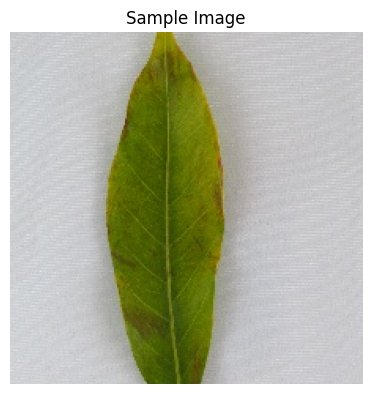

In [16]:
import matplotlib.pyplot as plt

# Show sample image
img_path = dataset_path + "/nitrogen-N/N (1).jpg"
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for correct color display

# Show original and augmented images side by side
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Sample Image")
plt.axis("off")

plt.show()

In [17]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2

In [39]:
img_size = 224
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 20% validation
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
)

train_gen = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='sparse',
    subset='training'
)

val_gen = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='sparse',
    subset='validation'
)


Found 1600 images belonging to 4 classes.
Found 400 images belonging to 4 classes.


In [40]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
base_model.trainable = False  # Freeze base

print(f"Total layers in base model: {len(base_model.layers)}")

Total layers in base model: 154


In [41]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(train_gen.class_indices), activation='softmax')
])

print(f"How many classes: {len(train_gen.class_indices)}")

How many classes: 4


In [42]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [43]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train model with early stopping
history = model.fit(train_gen, epochs=20, validation_data=val_gen, callbacks=[early_stopping])

# Unfreeze last few layers for fine-tuning  
base_model.trainable = True
for layer in base_model.layers[:50]:  # Freeze first 100 layers
    layer.trainable = False 

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 39s 728ms/step - accuracy: 0.4149 - loss: 1.3226 - val_accuracy: 0.5125 - val_loss: 1.1308
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 34s 684ms/step - accuracy: 0.7988 - loss: 0.6285 - val_accuracy: 0.5750 - val_loss: 0.9838
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 34s 675ms/step - accuracy: 0.8683 - loss: 0.4153 - val_accuracy: 0.6125 - val_loss: 0.9498
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 35s 693ms/step - accuracy: 0.9054 - loss: 0.3491 - val_accuracy: 0.6525 - val_loss: 0.9100
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 34s 680ms/step - accuracy: 0.8980 - loss: 0.3200 - val_accuracy: 0.6675 - val_loss: 0.8725
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 35s 702ms/step - accuracy: 0.9119 - loss: 0.2817 - val_accuracy: 0.6875 - val_loss: 0.8392
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 35s 693ms/step - accuracy: 0.9226 - loss: 0.2605 - val_accuracy: 0.6825 - val_loss: 0.8028
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 34s 679ms/step - accuracy: 0.9335 - loss: 0.2139 - val_accu

In [44]:
# Recompile model with lower learning rate for fine-tuning
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Continue training with fine-tuning
fine_tune_epochs = 20
history_fine = model.fit(train_gen, epochs=fine_tune_epochs, validation_data=val_gen, callbacks=[early_stopping])

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.4339 - loss: 1.9121 - val_accuracy: 0.6475 - val_loss: 1.0551
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8159 - loss: 0.5051 - val_accuracy: 0.6100 - val_loss: 1.2633
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.8753 - loss: 0.3530 - val_accuracy: 0.6175 - val_loss: 1.2620
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8785 - loss: 0.3115 - val_accuracy: 0.6250 - val_loss: 1.2811


In [49]:
model.save('leaf_deficiency_model.h5')

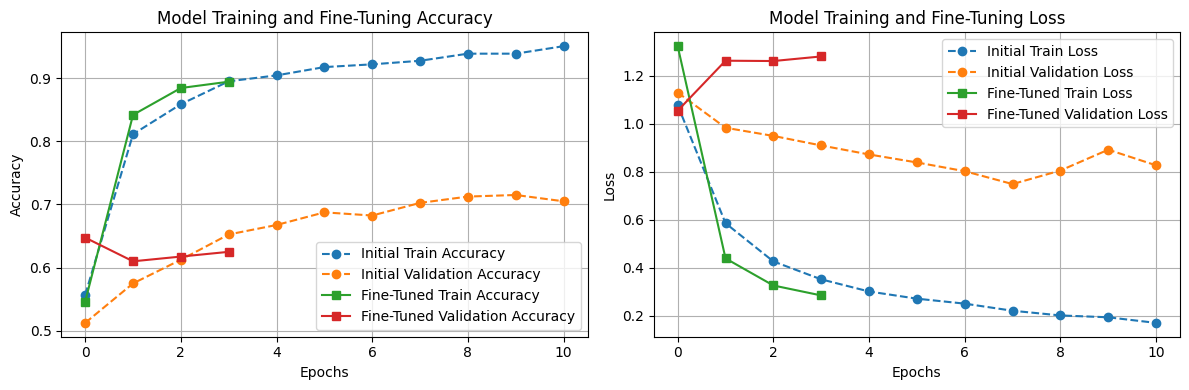

In [50]:
# Plot training history with labels and title
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)  # 1 row, 2 columns, plot 1
plt.plot(history.history['accuracy'], label='Initial Train Accuracy', linestyle='dashed', marker='o')
plt.plot(history.history['val_accuracy'], label='Initial Validation Accuracy', linestyle='dashed', marker='o')
plt.plot(history_fine.history['accuracy'], label='Fine-Tuned Train Accuracy', linestyle='solid', marker='s')
plt.plot(history_fine.history['val_accuracy'], label='Fine-Tuned Validation Accuracy', linestyle='solid', marker='s')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model Training and Fine-Tuning Accuracy")
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)  # 1 row, 2 columns, plot 2
plt.plot(history.history['loss'], label='Initial Train Loss', linestyle='dashed', marker='o')
plt.plot(history.history['val_loss'], label='Initial Validation Loss', linestyle='dashed', marker='o')
plt.plot(history_fine.history['loss'], label='Fine-Tuned Train Loss', linestyle='solid', marker='s')
plt.plot(history_fine.history['val_loss'], label='Fine-Tuned Validation Loss', linestyle='solid', marker='s')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Training and Fine-Tuning Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

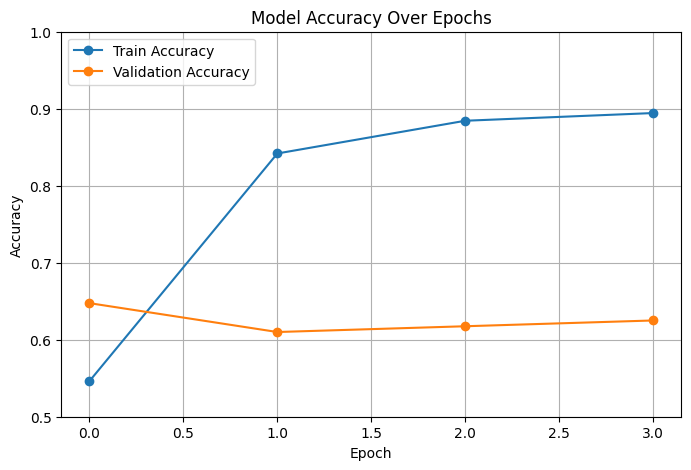

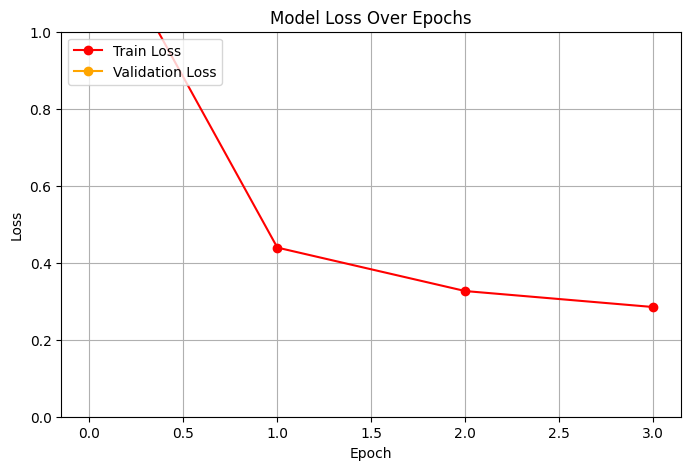

In [51]:
# Plot Accuracy
plt.figure(figsize=(8, 5))
plt.plot(history_fine.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history_fine.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.5, 1.0)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(8, 5))
plt.plot(history_fine.history['loss'], label='Train Loss', marker='o', color='red')
plt.plot(history_fine.history['val_loss'], label='Validation Loss', marker='o', color='orange')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0.0, 1.0)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# Classification testing
(can be run without running code above)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 822ms/step


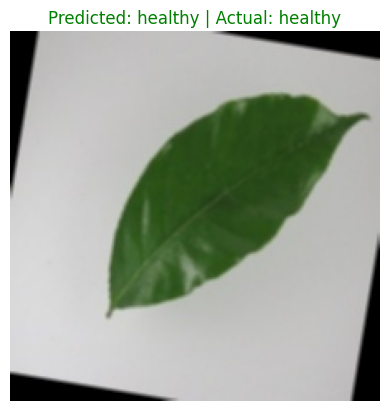

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


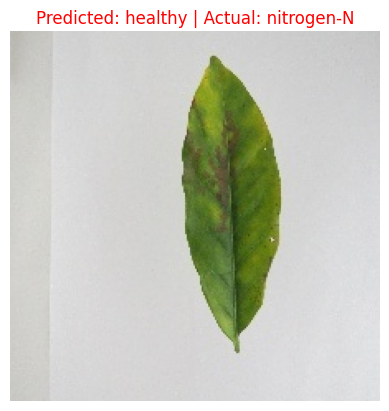

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


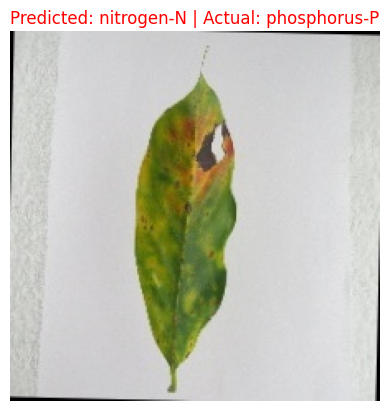

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


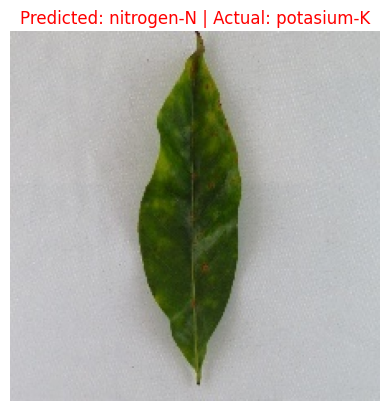

In [54]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# === Configuration ===
val_dir = "./dataset/CoLeaf DATASET - Condensed"
img_size = (224, 224)  # Use the size your model expects
class_names = ['healthy', 'nitrogen-N', 'phosphorus-P', 'potasium-K']
model_path = "leaf_deficiency_model.h5"

# === Load the model ===
model = load_model(model_path)

# === Collect one random image per class ===
selected_images = []
true_class_labels = []

for class_name in class_names:
    class_path = os.path.join(val_dir, class_name)
    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('jpg', 'jpeg', 'png'))]
    if not image_files:
        continue
    random_file = random.choice(image_files)
    img_path = os.path.join(class_path, random_file)
    selected_images.append(img_path)
    true_class_labels.append(class_name)

# === Predict and visualize ===
for i, img_path in enumerate(selected_images):
    img = load_img(img_path, target_size=img_size)
    img_array = img_to_array(img) / 255.0
    img_input = np.expand_dims(img_array, axis=0)

    pred = model.predict(img_input)
    pred_class_idx = np.argmax(pred[0])
    pred_class_name = class_names[pred_class_idx]

    # Show image and prediction
    plt.imshow(img)
    plt.title(f"Predicted: {pred_class_name} | Actual: {true_class_labels[i]}",
              color='green' if pred_class_name == true_class_labels[i] else 'red')
    plt.axis("off")
    plt.show()
